In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
%matplotlib inline

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '../../../../'
sys.path.insert(0,path_to_mavenn_local)

#Load mavenn and check path
import mavenn
print(mavenn.__path__)

# MAVE-NN utilities
from mavenn.src.mavedb import mutations_to_dataset

['../../../../mavenn']


In [2]:
abreviation_dict = {
    'Ala':'A', 
    'Arg':'R',
    'Asn':'N',
    'Asp':'D',
    'Cys':'C',
    'Glu':'E',
    'Gln':'Q',
    'Gly':'G',
    'His':'H',
    'Ile':'I',
    'Leu':'L',
    'Lys':'K',
    'Met':'M',
    'Phe':'F',
    'Pro':'P',
    'Ser':'S',
    'Thr':'T',
    'Trp':'W',
    'Tyr':'Y',
    'Val':'V'
}

aas = list(abreviation_dict.values())

In [3]:
# Load mave-db dataset
df = pd.read_csv('urn_mavedb_00000044-a-2_scores.csv', skiprows=17)
df.head()

,accession,hgvs_nt,hgvs_pro,score,avg_count,library
0,urn:mavedb:00000044-a-2#1,NaN,p.[Ala14Asp;Ala22Gln;Lys94Ala;Asp137Ser],NaN,3.54,2.0
1,urn:mavedb:00000044-a-2#2,NaN,p.[Asn4Tyr;Asn151Pro],-0.72,102.47,2.0
2,urn:mavedb:00000044-a-2#3,NaN,p.[Ile88Val;Tyr93Ser;Ser129Asn],-4.84,28.57,2.0
3,urn:mavedb:00000044-a-2#4,NaN,p.[Tyr119Ser;Ser129Asp],-1.31,128.08,2.0
4,urn:mavedb:00000044-a-2#5,NaN,p.[Asn24Gln;Phe62Arg;Asn107Pro;Tyr123Phe],-0.53,108.56,2.0


In [4]:
# Create y_df
y_df = pd.DataFrame()
y_df['y'] = df['score'].astype(float).copy()
print(f'len(y_df): {len(y_df)}')
y_df.head()

len(y_df): 195081


,y
0,NaN
1,-0.72
2,-4.84
3,-1.31
4,-0.53


In [5]:
# Parse hgvs notation
matches_list = [re.findall('([A-Za-z\*]+)([0-9]+)([A-Za-z\*]+)', s) for s in df['hgvs_pro']]

# Add hamming_dist col to y_df
y_df.insert(loc=0, column='hamming_dist', value=[len(m) for m in matches_list])

# Assign to trianing and test sets
N = len(y_df)
training_frac=.8
np.random.seed(0)
r = np.random.rand(N)
test_frac = .2
val_frac = .2
ix_train = (test_frac + val_frac <= r)
ix_val = (test_frac <= r) & (r < test_frac + val_frac)
ix_test = (r < test_frac)
y_df.insert(loc=0, column='set', value='')
y_df.loc[ix_train, 'set'] = 'training'
y_df.loc[ix_val, 'set'] = 'validation'
y_df.loc[ix_test, 'set'] = 'test'
assert all([len(x)>0 for x in y_df['set']])

y_df.head()

,set,hamming_dist,y
0,training,4,NaN
1,training,2,-0.72
2,training,3,-4.84
3,training,2,-1.31
4,training,4,-0.53


In [6]:
### Create mut_df

# Parse strings in 'hgvs_pro' column
f = open('tmp.txt','w')
f.write('id,l,c\n')
for i, matches in enumerate(matches_list):
    for _, l, c in matches:
        f.write(f'{i},{int(l)-1},{c}\n')
f.close()
mut_df = pd.read_csv('tmp.txt')

# Map long-form aa to short-form aa
mut_df['c'] = mut_df['c'].map(abreviation_dict).astype(str)

# Remove all unrecognized 'c'
ix = mut_df['c'].isin(aas)
mut_df = mut_df[ix]

# preview mut_df
print(f'min l: {min(mut_df["l"])}')
print(f'max l: {max(mut_df["l"])}')
print(f'max id: {max(mut_df["id"])}')
mut_df.head()

min l: 0
max l: 200
max id: 195080


,id,l,c
0,0,13,D
1,0,21,Q
2,0,93,A
3,0,136,S
4,1,3,Y


In [7]:
# Protein sequence determined from the wt coding DNA sequence in Snapgene
# 'AATATTACAAACTTGTGCCCTTTTGGTGAAGTTTTTAACGCCACCAGATTTGCATCTGTTTATGCTTGGAACAGGAAGAGAATCAGCAACTGTGTTGCTGATTATTCTGTCCTATATAATTCCGCATCATTTTCCACTTTTAAGTGTTATGGAGTGTCTCCTACTAAATTAAATGATCTCTGCTTTACTAATGTCTATGCAGATTCATTTGTAATTAGAGGTGATGAAGTCAGACAAATCGCTCCAGGGCAAACTGGAAAGATTGCTGATTATAATTATAAATTACCAGATGATTTTACAGGCTGCGTTATAGCTTGGAATTCTAACAATCTTGATTCTAAGGTTGGTGGTAATTATAATTACCTGTATAGATTGTTTAGGAAGTCTAATCTCAAACCTTTTGAGAGAGATATTTCAACTGAAATCTATCAGGCCGGTAGCACACCTTGTAATGGTGTTGAAGGTTTTAATTGTTACTTTCCTTTACAATCATATGGTTTCCAACCCACTAATGGTGTTGGTTACCAACCATACAGAGTAGTAGTACTTTCTTTTGAACTTCTACATGCACCAGCAACTGTTTGTGGACCTAAAAAGTCTACT'
wt_seq = 'NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST'
len(wt_seq)

201

In [8]:
# Create dataset
data_df = mutations_to_dataset(wt_seq=wt_seq, mut_df=mut_df, y_df=y_df)

# Dropna and reindex
data_df.dropna(inplace=True)
data_df.reset_index(inplace=True, drop=True)

data_df.head(10)

,set,hamming_dist,y,x
0,training,2,-0.72,NITYLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
1,training,3,-4.84,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
2,training,2,-1.31,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3,training,4,-0.53,NITNLCPFGEVFNATRFASVYAWQRKRISNCVADYSVLYNSASFST...
4,training,2,-4.84,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
5,training,2,-1.42,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
6,training,2,-0.75,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
7,validation,2,-0.94,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
8,training,2,-0.55,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
9,training,3,-4.84,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


In [9]:
# Save data_df
file_name = '../ace2rbd_data.csv.gz'
data_df.to_csv(file_name, compression='gzip', index=False)
!du -mh $file_name

2.0M	../ace2rbd_data.csv.gz


/Users/jkinney/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hamming_dist'>

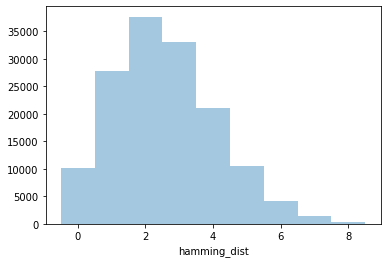

In [10]:
import seaborn as sns
sns.distplot(data_df['hamming_dist'], kde=False, bins=np.arange(10)-.5)